# Exploration des données récoltées

Après le scrapping du site Spoticar, il est important d'analyser rapidement les données dont nous disposons.
Le notebook ci-présenté servira donc ce point.

In [1]:
from serde import serde
from serde.json import to_json, from_json
from dataclasses import dataclass
from time import sleep
from scrapping import Voiture
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import statsmodels
import conversion_df 
from importlib import reload

reload(conversion_df)

<module 'conversion_df' from 'c:\\Users\\mathi\\Documents\\Cours\\M2\\Machine Learning\\VERON_NEPVEUX_PROJECT\\veron_nepveux_project\\conversion_df.py'>

Le premier point est d'abord d'importer les packages nécessaires pour les représentations visuelles et l'analyse statistique.

In [2]:
df = conversion_df.data_frame_pandas('donnees_peugeot.json')
df_cat = conversion_df.data_frame_dummies(df)

On transforme ensuite les données en deux dataframe distincts à l'aide de `pandas` : 

- Le premier prenant les données de manière classique.
- Le second mettant les données catégorielles sous forme de variables dichotomiques.

On note que le tri de la base de données a été fait précedemment et la données manquantes ont été supprimées.

# Variables

Le tableau ci-dessous résume les variables composant la base de données : 
| Variable   |      Type      | Description    |
|:-|:-|:-|
| `modele` |Catégorielle| Nom du modèle de véhicule| 
| `carburant` |Catégorielle| Type de carburant ou d'alimentation | 
| `prix` |Numérique| Prix du véhicule sur le site|
| `kilometrage` |Numérique| Kilométrage du véhicule |
| `garantie_kilometrage` |Dichotomique| Indicateur de fiabilité concernant la valeur du kilométrage |
| `boite_de_vitesse` |Catégorielle| Type de boîte de vitesse |
| `transmission` |Numérique| Nombre de roues motrices | 
| `couleur` |Catégorielle| Couleur du véhicule | 
|  `garantie` |Dichotomique| Type de garantie proposé par le site vendeur | 
| `date_mise_circulation` |Numérique| Année de mise en  circulation du véhicule| 
| `puissance` |Numérique| Puissance du moteur(en cv) |
| `silhouette` |Catégorielle| Type de véhicule | 
| `nb_places` |Numérique| Nombre de places | 
| `utilisation_pred` |Catégorielle| Précédente utilisation/propriétaire du véhicule | 
| `puissance_fiscale` |Numérique| Puissance fiscale du véhicule (en cv) |
| `critait` |Numérique| Indice Crit'air du véhicule | 
| `ptac` |Numérique| PTAC du véhicule | 
| `nb_portes` |Numérique| Nombre de portes | 

La base de données ne comprends pas les options des véhicules, en effet celles-ci sont particulières aux modèles en eux-mêmes et présentent l'inconvénient d'être bien plus difficile à récupérer que les autres données.

## Analyse descriptive

In [3]:
df.describe().round()

,prix,kilometrage,transmission,date_mise_circulation,puissance,nb_places,puissance_fiscale,critair,ptac,nb_portes
count,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
mean,26750.0,28932.0,2.0,2020.0,122.0,5.0,6.0,1.0,1875.0,5.0
std,8836.0,29263.0,0.0,2.0,27.0,1.0,2.0,1.0,273.0,0.0
min,7490.0,3.0,2.0,2011.0,6.0,2.0,3.0,0.0,1240.0,3.0
25%,19722.0,7000.0,2.0,2019.0,102.0,5.0,5.0,1.0,1680.0,5.0
50%,26240.0,19521.0,2.0,2021.0,130.0,5.0,6.0,2.0,1875.0,5.0
75%,33525.0,41282.0,2.0,2022.0,131.0,5.0,7.0,2.0,2000.0,5.0
max,59980.0,176600.0,4.0,2022.0,225.0,8.0,13.0,2.0,3500.0,5.0


Ce premier tableau nous présente les valeurs statistiques des données, on peut voir que le `prix` est en moyenne de 26 750 € pour les véhicules analysés, pour un `kilométrage` moyen de 28 932 km.

Le `prix` minimum est de 7 490 €, ce qui montre que les véhicules sont tout de mêmes dans un état minimum bon, il en est de même pour le `kilométrage` maximum qui est de 176 600 km.

### Graphiques de répartition

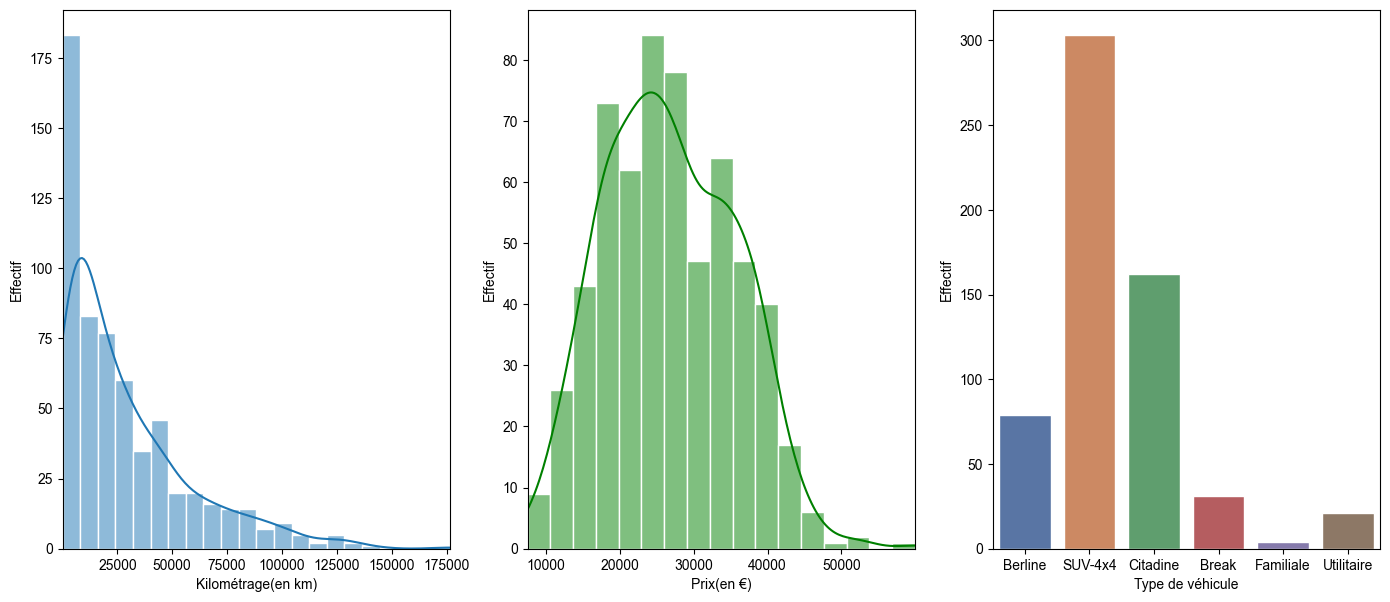

In [4]:
fig, ax = plt.subplots(1,3, figsize=(17,7))
sns.set_theme(style="whitegrid")
sns.histplot(data = df_cat, x = "kilometrage", kde = True, ax=ax[0])
ax[0].set_xlim(min(df['kilometrage']),max(df['kilometrage']))
ax[0].set_xlabel("Kilométrage(en km)")
ax[0].set_ylabel("Effectif")

sns.histplot(data = df_cat, x = "prix", kde = True, ax=ax[1], color = "green")
ax[1].set_xlim(min(df['prix']),max(df['prix']))
ax[1].set_xlabel("Prix(en €)")
ax[1].set_ylabel("Effectif")

sns.countplot(data=df, x='silhouette', ax=ax[2])
ax[2].set_xlabel("Type de véhicule")
ax[2].set_ylabel("Effectif")

plt.show()

Ces trois graphiques concernent donc la répartition de certaines variables de notre base de données :

- Kilométrage
- Prix
- Type de véhicule

On peut tout d'abord observer que la répartition des kilométrages semble suivre une loi de type Poisson par exemple, où l'on observe cette décroissance dans les effectifs avec l'augmentation des valeurs. On sait donc que nos données concernent en majeure partie des véhicules peu usés.

Ensuite, concernant le prix, celui-ci semble suivre une loi normale centrée sur environ 25 000 €, et ne comporte pas de valeur abberante.

Enfin, pour les types de véhicules, on fait affaire en majorité à des `SUV 4x4` qui représente aujourd'hui en grande partie les ventes de la marque Peugeot (2008, 3008, 5008), il n'y a donc rien de suprenant dans ces valeurs.

## Graphiques de corrélation et de relation

Dans cette partie, les graphiques serviront à représenter et à voir les relations qu'il peut exister entre les variables et qui peuvent influencer le modèle construit plus tard.

C:\Users\mathi\AppData\Local\Temp\ipykernel_28520\800799425.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


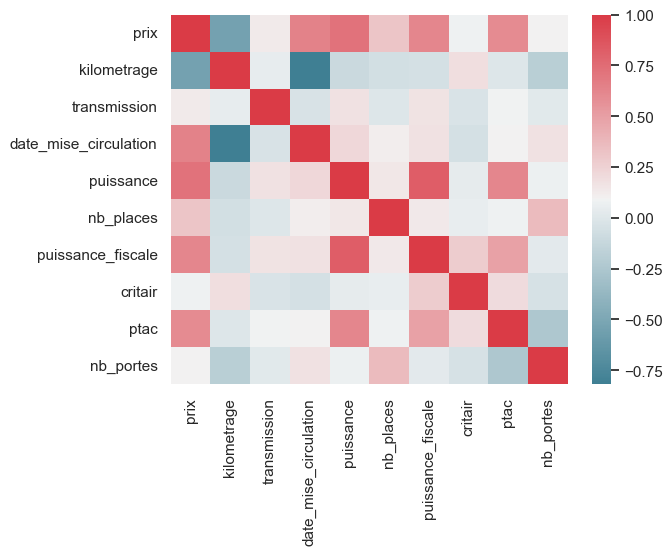

In [5]:
corr = df.corr()
corplot = sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True))

Ce graphique permet de rendre compte des corrélation existantes entre les données. De part la présence de données catégorielle, celles-ci ne sont pas prise en compte de par leur trop grand nombre de modalité. On observe cependant certaines corrélations qui semblent intéressantes :

- Le `kilometrage` et le `prix` sont fortement liés, et le premier tend à faire baisser le deuxième.
- La `puissance` semble aussi impacter le `prix`, mais de manière positive cette fois.

On peut remarquer que les variables `critair`, `transmission` et `nb_portes` ne semble pas avoir de corrélations avec le prix.

Pour observer les relations des variables catégorielles, nous allons utiliser des graphiques.

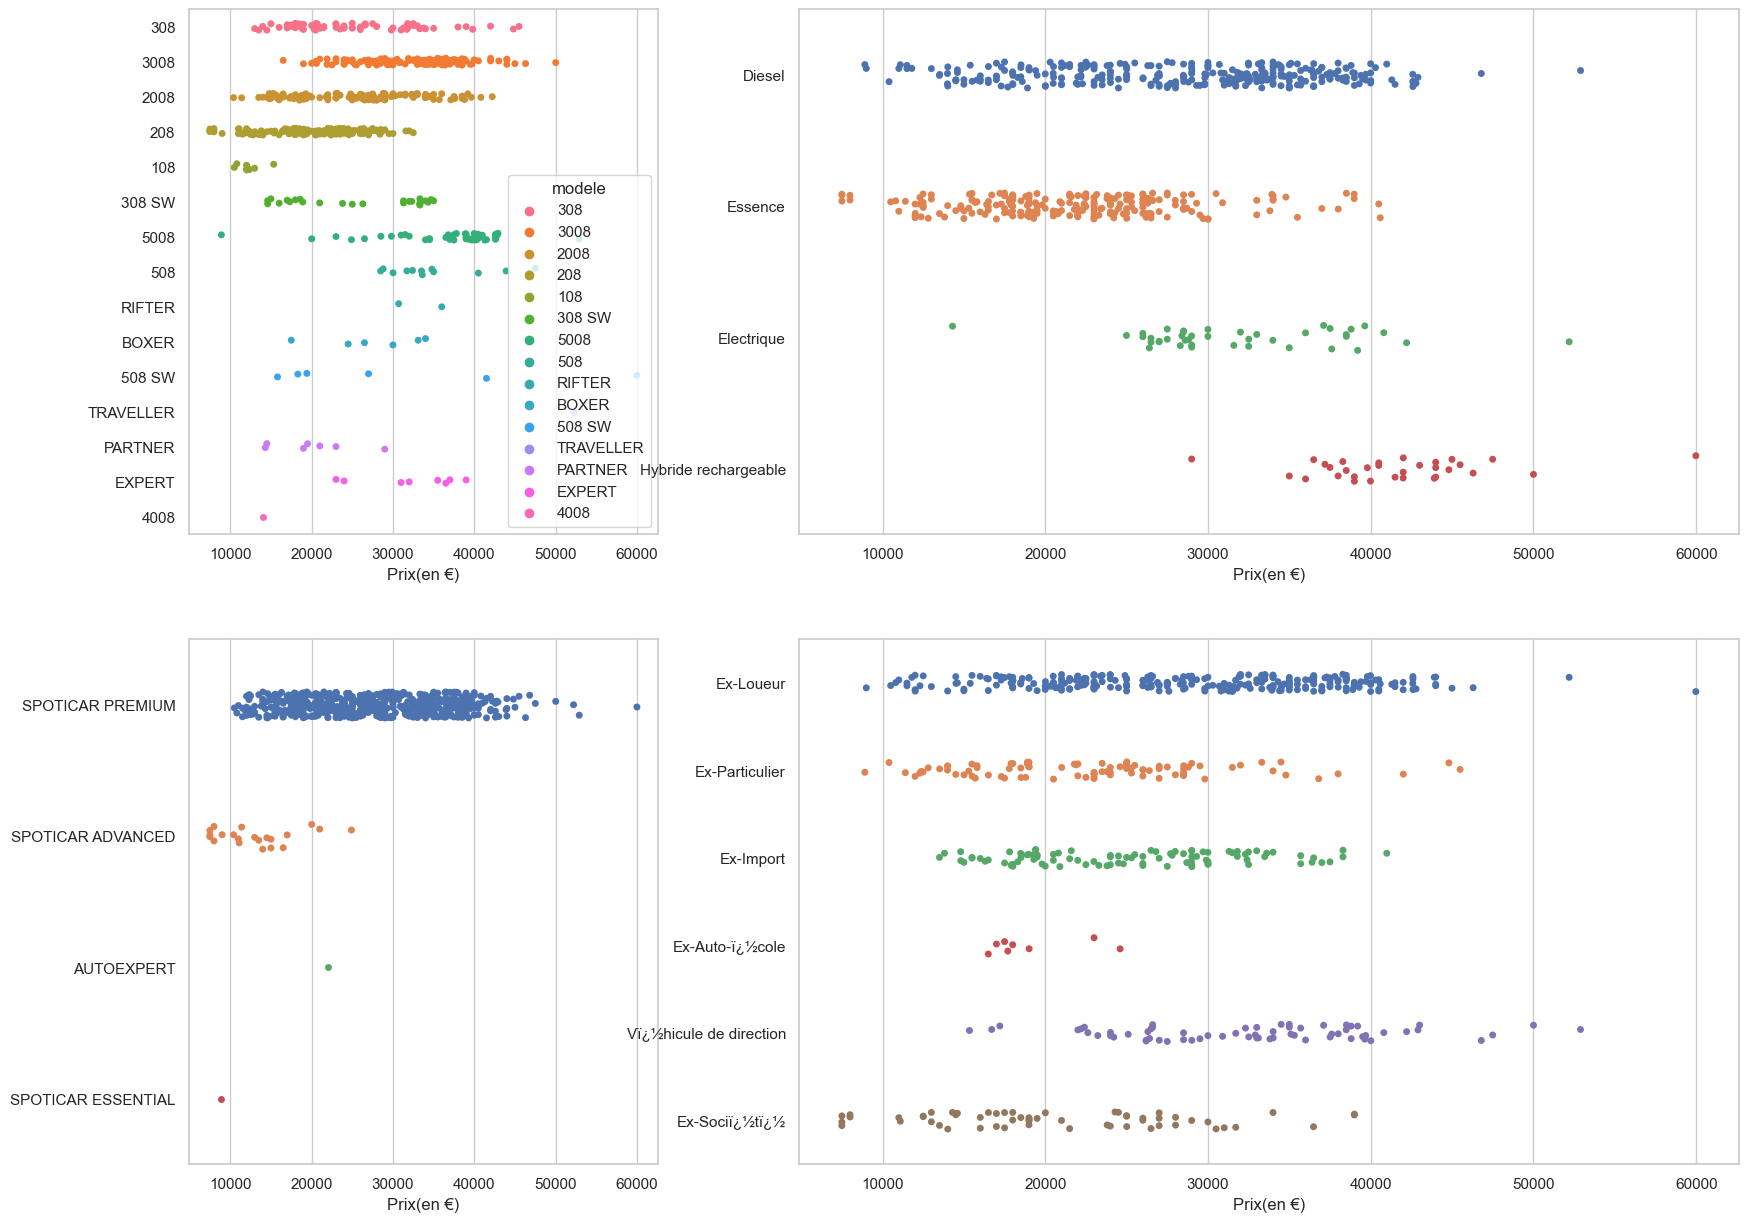

In [6]:
fig, ax = plt.subplots(2,2, figsize = (20,15), width_ratios=[1, 2])

sns.stripplot(data=df, x='prix', y='modele', hue='modele',ax=ax[0,0])
ax[0,0].set_xlabel('Prix(en €)')
ax[0,0].set_ylabel('')

sns.stripplot(data=df, x='prix', y='carburant', hue='carburant', legend=False, ax=ax[0,1])
font2 = {'family':'serif','color':'darkred','size':15}
ax[0,1].set_xlabel('Prix(en €)')
ax[0,1].set_ylabel('')


sns.stripplot(data=df, x='prix', y='garantie', hue='garantie', legend=False, ax=ax[1,0])
ax[1,0].set_xlabel('Prix(en €)')
ax[1,0].set_ylabel('')

sns.stripplot(data=df, x='prix', y='utilisation_prec', hue='utilisation_prec', legend=False, ax=ax[1,1])
ax[1,1].set_xlabel('Prix(en €)')
ax[1,1].set_ylabel('')

plt.rc('ytick', labelsize=8)
plt.show()

Ces quatres graphiques permettent de mettre en lumière les relations qui pourraient exister entre le `prix` et différentes variables catégorielles. 